In [1]:
%load_ext autoreload

In [2]:
%autoreload

import copy

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.table import Table
from prfr import ProbabilisticRandomForestRegressor, split_arrays
from scipy.signal import savgol_filter
import pickle

plt.rcParams["axes.labelsize"] = 25
plt.rcParams["axes.titlesize"] = 25
plt.rcParams["xtick.labelsize"] = 25
plt.rcParams["ytick.labelsize"] = 25
plt.rcParams["figure.figsize"] = (11, 7)

import warnings
warnings.filterwarnings("ignore")

In [11]:
alldata = Table.read("bp_rp_lamost_pristine.fits").to_pandas().dropna()#.drop_duplicates(subset='source_id')

In [12]:
alldata.shape

(721158, 241)

In [13]:
alldata

,CaHK,CaHKerr,Flag,EBV_1,source_id_1,RA_1,DEC_1,Gmag,BPmag,RPmag,...,rpe_46,rpe_47,rpe_48,rpe_49,rpe_50,rpe_51,rpe_52,rpe_53,rpe_54,rpe_55
0,22.139000,0.003,-1,0.031,3925137081005760256,180.74255,15.87772,14.263000,14.578000,13.788000,...,0.508185,0.402310,0.427371,0.403846,0.397516,0.359073,0.287136,0.268199,0.096512,0.053816
1,22.482000,0.003,-1,0.032,3925140413900382848,180.71665,15.92427,13.456000,13.982000,12.782000,...,0.772136,0.640554,0.714950,0.590955,0.586265,0.626511,0.477989,0.432279,0.159667,0.080057
2,22.028000,0.003,-1,0.033,3925153779838585216,180.64154,16.00639,14.154000,14.477000,13.668000,...,0.498129,0.392264,0.447194,0.402162,0.378958,0.386324,0.299255,0.259726,0.103423,0.046358
3,22.169001,0.003,-1,0.034,3925114266139458048,180.59605,15.78419,14.290000,14.610000,13.804000,...,0.439055,0.352982,0.396571,0.330580,0.335493,0.355098,0.271817,0.224544,0.088368,0.042054
4,21.768999,0.003,-1,0.036,3925114987693963008,180.48022,15.79058,13.342000,13.778000,12.741000,...,0.726871,0.602316,0.672446,0.574542,0.527627,0.541587,0.430425,0.399471,0.147763,0.073385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721166,24.702000,0.011,1,0.012,1583588050154909952,189.43682,62.25446,16.358000,16.761000,15.788000,...,0.217060,0.182942,0.143008,0.145522,0.160850,0.123847,0.116819,0.105467,0.051689,0.031885
721167,25.153999,0.016,1,0.013,1580726085812436992,190.09254,62.89752,16.586000,17.039000,15.965000,...,0.239773,0.198931,0.182888,0.179838,0.186425,0.167500,0.140454,0.126725,0.061070,0.033860
721168,23.844000,0.008,-1,0.015,1580616723060176512,190.23564,62.48165,16.504999,16.759001,16.084000,...,0.254138,0.206533,0.199182,0.185607,0.187154,0.142432,0.141647,0.124157,0.060482,0.030560
721169,24.473000,0.011,-1,0.013,1580617169736778240,190.12852,62.53711,16.066000,16.493999,15.467000,...,0.310071,0.282012,0.269572,0.230447,0.233432,0.227826,0.200662,0.172950,0.071736,0.041835


In [14]:
# alldata = alldata[alldata["logg"] < 7]
# alldata = alldata[alldata["logg"] > 3.5]
# alldata = alldata[alldata["teff"] < 7000]
# alldata = alldata[(alldata["EBV_1"] < 0.1) & (alldata["FeHphot_gen"] > -5.0)]
alldata = alldata[(alldata["FeHphot_gen"] < -1)] # new one, looking for metal poor stars.
# consider cuts on other parameters?

In [15]:
alldata.dropna()
alldata.shape
# newdata.dropna()
# newdata.shape

(60431, 241)

In [16]:
# data = alldata.sample(n = 100000, random_state = 42)
data = alldata
data.shape
# # data = newdata
# # data.shape

(60431, 241)

In [17]:
# fmt: off
names_X = [ "bp_1", "bp_2", "bp_3", "bp_4", "bp_5", "bp_6", "bp_7", "bp_8", "bp_9", "bp_10", "bp_11", "bp_12", "bp_13", "bp_14", "bp_15", "bp_16", "bp_17", "bp_18", "bp_19", "bp_20", "bp_21", "bp_22", "bp_23", "bp_24", "bp_25", "bp_26", "bp_27", "bp_28", "bp_29", "bp_30", "bp_31", "bp_32", "bp_33", "bp_34", "bp_35", "bp_36", "bp_37", "bp_38", "bp_39", "bp_40", "bp_41", "bp_42", "bp_43", "bp_44", "bp_45", "bp_46", "bp_47", "bp_48", "bp_49", "bp_50", "bp_51", "bp_52", "bp_53", "bp_54", "bp_55", "rp_1", "rp_2", "rp_3", "rp_4", "rp_5", "rp_6", "rp_7", "rp_8", "rp_9", "rp_10", "rp_11", "rp_12", "rp_13", "rp_14", "rp_15", "rp_16", "rp_17", "rp_18", "rp_19", "rp_20", "rp_21", "rp_22", "rp_23", "rp_24", "rp_25", "rp_26", "rp_27", "rp_28", "rp_29", "rp_30", "rp_31", "rp_32", "rp_33", "rp_34", "rp_35", "rp_36", "rp_37", "rp_38", "rp_39", "rp_40", "rp_41", "rp_42", "rp_43", "rp_44", "rp_45", "rp_46", "rp_47", "rp_48", "rp_49", "rp_50", "rp_51", "rp_52", "rp_53", "rp_54", "rp_55", ] 
names_eX = [ "bpe_1", "bpe_2", "bpe_3", "bpe_4", "bpe_5", "bpe_6", "bpe_7", "bpe_8", "bpe_9", "bpe_10", "bpe_11", "bpe_12", "bpe_13", "bpe_14", "bpe_15", "bpe_16", "bpe_17", "bpe_18", "bpe_19", "bpe_20", "bpe_21", "bpe_22", "bpe_23", "bpe_24", "bpe_25", "bpe_26", "bpe_27", "bpe_28", "bpe_29", "bpe_30", "bpe_31", "bpe_32", "bpe_33", "bpe_34", "bpe_35", "bpe_36", "bpe_37", "bpe_38", "bpe_39", "bpe_40", "bpe_41", "bpe_42", "bpe_43", "bpe_44", "bpe_45", "bpe_46", "bpe_47", "bpe_48", "bpe_49", "bpe_50", "bpe_51", "bpe_52", "bpe_53", "bpe_54", "bpe_55", "rpe_1", "rpe_2", "rpe_3", "rpe_4", "rpe_5", "rpe_6", "rpe_7", "rpe_8", "rpe_9", "rpe_10", "rpe_11", "rpe_12", "rpe_13", "rpe_14", "rpe_15", "rpe_16", "rpe_17", "rpe_18", "rpe_19", "rpe_20", "rpe_21", "rpe_22", "rpe_23", "rpe_24", "rpe_25", "rpe_26", "rpe_27", "rpe_28", "rpe_29", "rpe_30", "rpe_31", "rpe_32", "rpe_33", "rpe_34", "rpe_35", "rpe_36", "rpe_37", "rpe_38", "rpe_39", "rpe_40", "rpe_41", "rpe_42", "rpe_43", "rpe_44", "rpe_45", "rpe_46", "rpe_47", "rpe_48", "rpe_49", "rpe_50", "rpe_51", "rpe_52", "rpe_53", "rpe_54", "rpe_55", ] 
names_Y = ["FeHphot_gen", "logg", "teff"]
names_norm = ["phot_g_mean_mag"]

In [18]:
normalize = lambda x, n: x / (10 ** (8.5 - n / 2.5))

In [19]:
# features = normalize(data[names_X].to_numpy(), data[names_norm].to_numpy())
features = data[names_X].to_numpy()
# efeatures = normalize(data[names_eX].to_numpy(), data[names_norm].to_numpy())
efeatures = data[names_eX].to_numpy()
labels = data[names_Y].to_numpy()

# labels[:, -1] = np.log(labels[:, -1])  # log ages
labels[:, 1] = labels[:, 1] - labels[:, 0]  # turn mg/h into mg/fe

train, test, valid = split_arrays(
    features,
    efeatures,
    labels,
    # data['source_id'],
    test_size=0.2,
    valid_size=0.2,
)

In [32]:
features.shape

(60431, 110)

In [20]:
model = ProbabilisticRandomForestRegressor(
    n_jobs=-1,
)

In [21]:
train[1].shape

(38675, 110)

In [22]:
model.fit(
    train[0],
    train[2],
    eX=train[1],
    eY=1.,
)

Fitting model:   0%|          | 0/100 [00:00<?, ?it/s]

ProbabilisticRandomForestRegressor(n_jobs=-1)

In [23]:
model.calibrate(valid[0], 
                valid[2], 
                eX=valid[1], 
                eY=1.,
                apply_bias=True)
model.fit_bias(valid[0], 
               valid[2], 
               eX=valid[1])

Predicting:   0%|          | 0/100 [00:00<?, ?it/s]

Unscaling labels:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Predicting:   0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
# with open('prfr_lamost_photmet.pkl', 'wb') as fp:
    # pickle.dump(model, fp)

In [25]:
%%time

# preds = model.predict(test[0], eX=test[1], return_bias=False, apply_bias=False)
preds, biases = model.predict(test[0], eX=test[1], return_bias=True)

residual = test[2] - np.mean(preds, axis=-1)
print(residual.mean(axis=0))
print(residual.std(axis=0))

Predicting:   0%|          | 0/100 [00:00<?, ?it/s]

Unscaling labels:   0%|          | 0/100 [00:00<?, ?it/s]

[-0.00749368  0.01091201 -0.71949201]
[  0.34668385   0.46642675 203.65040935]
CPU times: user 8.54 s, sys: 2.69 s, total: 11.2 s
Wall time: 7.28 s


In [26]:
np.abs((biases[:,:,0] / preds.std(axis=-1))) > 3.

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       ...,
       [False, False, False],
       [False, False, False],
       [False, False, False]])

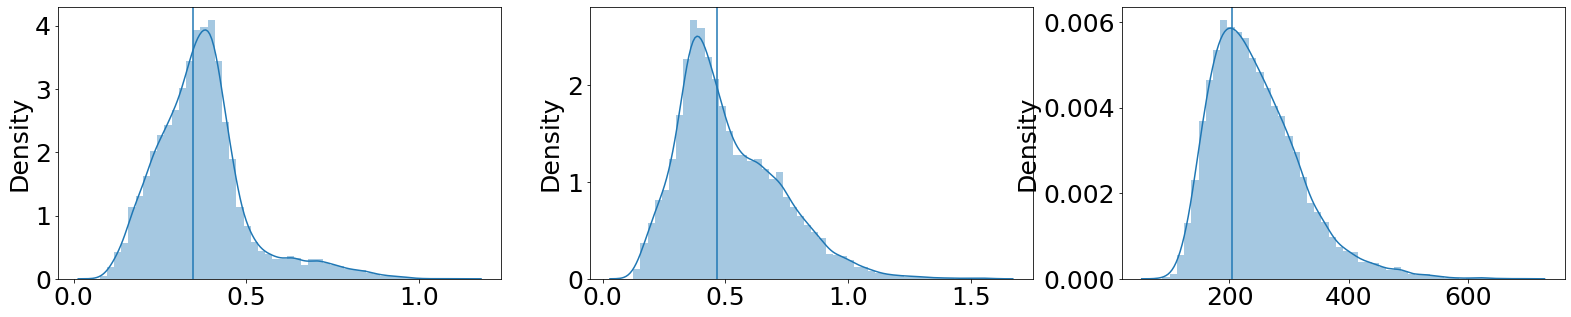

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(27, 5))
biases = np.std(test[2][:, :, None] - preds, axis=-1)
for i in range(3):
    sns.distplot(biases[:, i], ax=ax[i])
    ax[i].axvline(residual.std(axis=0)[i])
# print(residual.mean(axis=0), residual.std(axis=0))

Text(0.5, 1.0, 'Teff LAMOST')

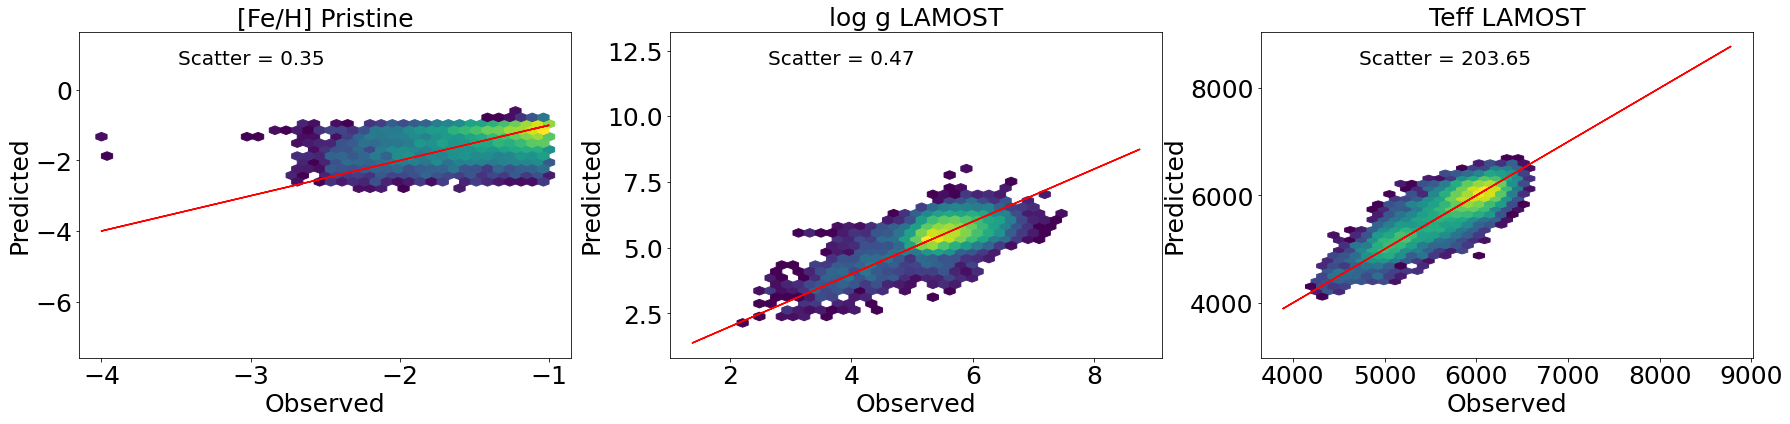

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(30, 6))
ax[0].set_ylabel('Predicted')
ax[1].set_ylabel('Predicted')
ax[2].set_ylabel('Predicted')
ax[0].set_xlabel('Observed')
ax[1].set_xlabel('Observed')
ax[2].set_xlabel('Observed')
for i in range(3):
    ax[i].hexbin(
        test[2][:, i],
        preds[:, i, 0],
        gridsize=40,
        mincnt=5,
        norm=matplotlib.colors.LogNorm(),
    )
    ax[i].plot(test[2][:, i], test[2][:, i], c="r", zorder=5)
    ax[i].annotate(
        f"Scatter = {residual.std(axis=0)[i]:.2f}",
        (0.2, 0.9),
        xycoords="axes fraction",
        fontsize=20,
    )
ax[0].set_title("[Fe/H] Pristine")
# ax[0].set_ylim(-4,1.5)
ax[1].set_title("log g LAMOST")
ax[2].set_title("Teff LAMOST")
# plt.savefig('photmetcolourssbiaspristinenonorm.png')

Text(0.5, 1.0, 'Teff LAMOST')

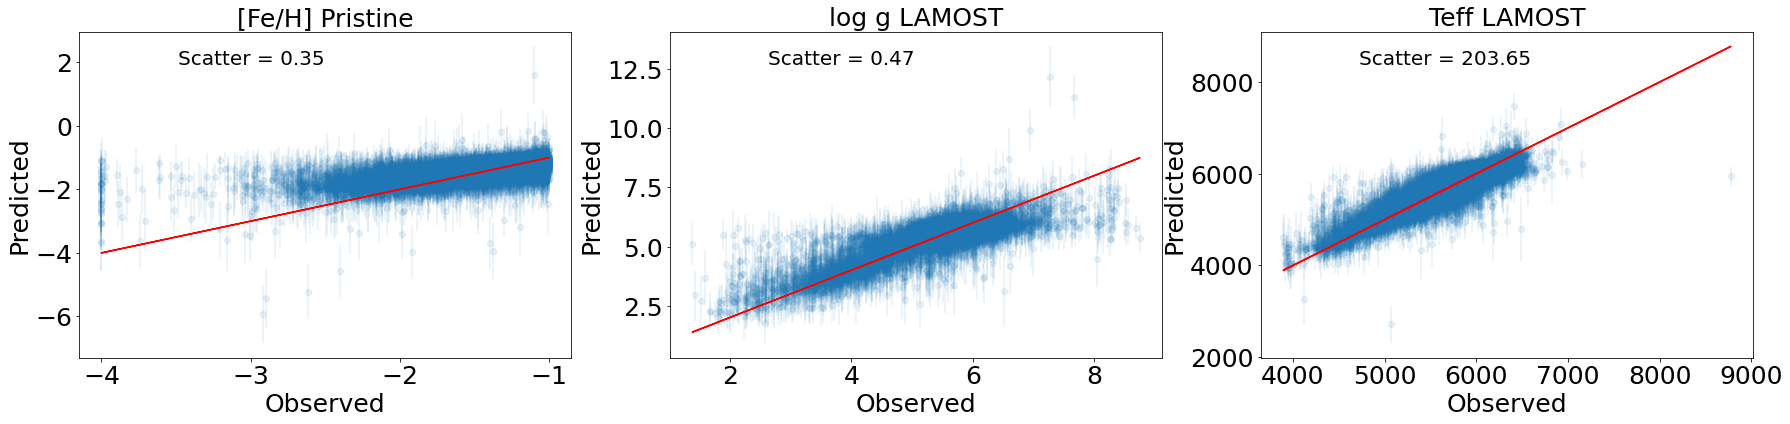

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(30, 6))
for i in range(3):
    ax[i].errorbar(
        test[2][:, i].flatten(),
        np.median(preds, axis=-1)[:, i],
        yerr=preds.std(axis=-1)[:, i],
        ls="none",
        marker="o",
        alpha=0.1,
    )
    ax[i].plot(test[2][:, i], test[2][:, i], c="r", zorder=5)
    ax[i].annotate(
        f"Scatter = {residual.std(axis=0)[i]:.2f}",
        (0.2, 0.9),
        xycoords="axes fraction",
        fontsize=20,
    )
ax[0].set_ylabel('Predicted')
ax[1].set_ylabel('Predicted')
ax[2].set_ylabel('Predicted')
ax[0].set_xlabel('Observed')
ax[1].set_xlabel('Observed')
ax[2].set_xlabel('Observed')
ax[0].set_title("[Fe/H] Pristine")
ax[1].set_title("log g LAMOST")
ax[2].set_title("Teff LAMOST")
# plt.savefig('photmeterrorsbiaspristinenonorm.png')

Text(0.5, 1.0, 'Teff')

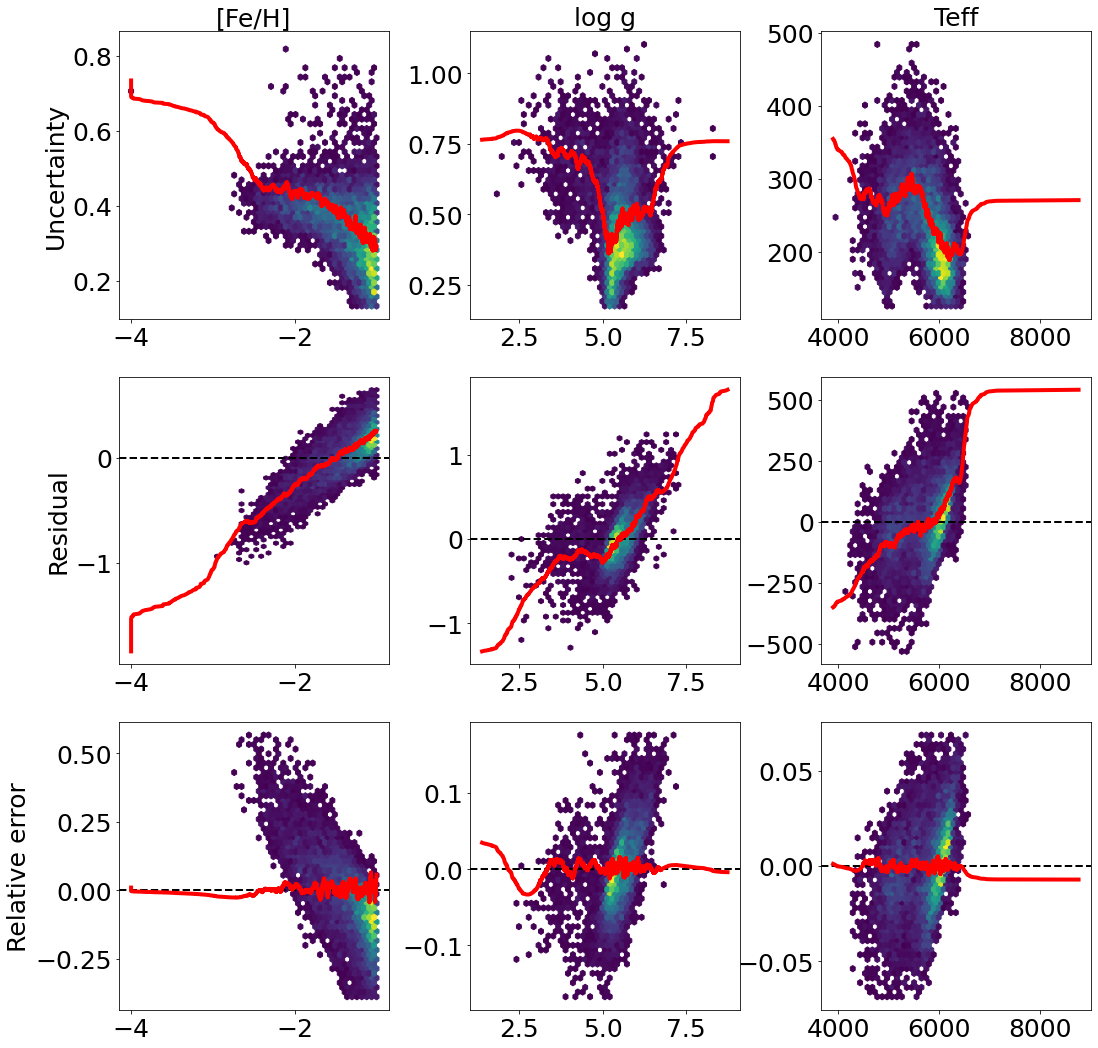

In [30]:
fig = plt.figure(figsize=(30, 18))
gs = fig.add_gridspec(nrows=3, ncols=5, wspace=0.3)
ax = np.stack(
    [np.array([fig.add_subplot(gs[i, j]) for j in range(3)]) for i in range(3)]
)
xplt = test[2]
# xplt = preds.mean(axis=-1)
for i in range(3):
    ax[0, i].hexbin(
        xplt[:, i],
        preds[:, i].std(axis=-1),
        mincnt=3,
        gridsize=50,
        extent=[
            xplt[:,i].min(),
            xplt[:,i].max(),
            *np.quantile(preds[:, i].std(axis=-1), [0.01, 0.99]),
        ],
    )
    sortidx = np.argsort(xplt[:, i])
    ax[0, i].plot(
        xplt[:, i][sortidx],
        savgol_filter(preds[:, i].std(axis=-1)[sortidx], 400, 3),
        c="r",
        zorder=6,
        lw=4,
    )

    ax[1, i].hexbin(
        xplt[:, i],
        residual[:, i],
        mincnt=3,
        gridsize=50,
        extent=[
            xplt[:, i].min(),
            xplt[:, i].max(),
            *np.quantile(residual[:, i], [0.01, 0.99]),
        ],
    )
    ax[1, i].axhline(0, c="k", ls="--", lw=2, zorder=5)
    sortidx = np.argsort(xplt[:, i])
    ax[1, i].plot(
        xplt[:, i][sortidx],
        savgol_filter(residual[:, i][sortidx], 600, 3),
        c="r",
        zorder=6,
        lw=4,
    )

    y2 = residual[:, i] / xplt[:, i][sortidx]
    ax[2, i].hexbin(
        xplt[:, i],
        y2,
        mincnt=3,
        gridsize=50,
        extent=[
            xplt[:, i].min(),
            xplt[:, i].max(),
            *np.quantile(y2, [0.03, 0.97]),
        ],
    )
    ax[2, i].axhline(0, c="k", ls="--", lw=2, zorder=5)
    sortidx = np.argsort(xplt[:, i])
    ax[2, i].plot(
        xplt[:, i][sortidx],
        savgol_filter(y2, 600, 3),
        c="r",
        zorder=6,
        lw=4,
    )

ax[0, 0].set_ylabel("Uncertainty")
ax[1, 0].set_ylabel("Residual")
ax[2, 0].set_ylabel("Relative error")

ax[0, 0].set_title("[Fe/H]")
ax[0, 1].set_title("log g")
ax[0, 2].set_title("Teff")
# ax[0, 1].set_title("[Mg/Fe]")
# ax[0, 2].set_title("log g")
# ax[0, 3].set_title("Teff")
# ax[0, 4].set_title("Age")

# manual adjustments
# ax[2, 0].set_ylim(-2.0, 2.0)
# ax[2, 1].set_ylim(-1.2, 1.2)

In [31]:
# fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=True, sharex=True)
# args = dict(gridsize=50, mincnt=2, extent=[-1, 0.6, -0.05, 0.4])
# ax[0].hexbin(test[2][:, 0], test[2][:, 1], **args)#, C=test[2][:, 4])
# ax[1].hexbin(
#     preds[:, 0].mean(axis=-1),
#     preds[:, ].mean(axis=-1),
#     # C=preds[:, 4].mean(axis=-1),
#     **args
# )
# hb = ax[2].hexbin(preds[:, 0, :1].flatten(), preds[:, 1, :1].flatten(), **args)#, C=preds[:, 4, :1].flatten())
# plt.colorbar(hb, ax=ax[2])

In [ ]:
# fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=True, sharex=True)
# args = dict(gridsize=50, mincnt=2)
# ax[0].hexbin(test[2][:, 2], test[2][:, 1], **args)
# ax[1].hexbin(preds[:, 2].mean(axis=-1), preds[:, 1].mean(axis=-1), **args)
# ax[2].hexbin(preds[:, 2, 0], preds[:, 1, 0], **args)

# for a in ax:
#     a.invert_xaxis()
#     a.invert_yaxis()
# # ax[0].set_xlim(5200, 3800)
# # ax[0].set_ylim(3.7, 0.8)
# # ax[1].set_xlim(ax[0].get_xlim())
# # ax[1].set_ylim(ax[0].get_ylim())
# # ax[2].set_xlim(ax[0].get_xlim())
# # ax[2].set_ylim(ax[0].get_ylim())

In [ ]:
# fig = plt.figure(figsize=(25, 20))

# for i in range(3):
#     for j in range(3):
#         idx = i * 5 + j + 1
#         ax = fig.add_subplot(5, 5, idx)
#         sns.distplot(preds[idx][-1].flatten(), ax=ax)
#         ax.axvline(test[2][idx, -1], c="r")
#         ax.yaxis.set_visible(False)

# plt.subplots_adjust(wspace=0.0)

In [ ]:
# matches, idx1, idx2 = np.intersect1d(alldata['source_id'], data['source_id'], return_indices=True)
# alldata['in_sample'] = 1

In [ ]:
# features = normalize(alldata[names_X].to_numpy(), alldata[names_norm].to_numpy())
# labels = alldata['in_sample'].to_numpy()
# labels = (alldata['logg'].to_numpy() < 3.5).astype(int)
# train, test = split_arrays(features, labels, test_size=0.2)

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import roc_curve, RocCurveDisplay, auc, PrecisionRecallDisplay
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# clf1 = LogisticRegression(n_jobs=-1, max_iter=1000, solver='saga', tol=1e-2, penalty='none')
# clf2 = RandomForestClassifier(n_jobs=-1)

In [ ]:
# %%time
# clf1.fit(train[0], train[1])
# clf2.fit(train[0], train[1])

In [ ]:
# probs1 = clf1.predict_proba(test[0])[:,1]
# probs2 = clf2.predict_proba(test[0])[:,1]

In [ ]:
# xplot = np.linspace(0, 1, 1000)
# recalls = np.array([test[1][(probs1 > 0.5145) & (probs2 > i)].sum() / test[1].sum() for i in xplot])
# precisions = np.array([test[1][(probs1 > 0.5145) & (probs2 > i)].sum() / ((probs1 > 0.5145) & (probs2 > i)).sum() for i in xplot])
# f1s = 2. * (recalls * precisions) / (recalls + precisions)
# # plt.plot(xplot, recalls)
# # plt.plot(xplot, precisions)
# plt.scatter(xplot, f1s, c=xplot)
# plt.colorbar()
# bestidx = np.nanargmax(f1s)
# xplot[bestidx], recalls[bestidx], precisions[bestidx]
# # 0.5965965965965966, 0.9817908398443885, 0.9837203969995741
# # (0.46546546546546547, 0.9678315734414332, 0.9299805239680844)
# # (0.5145145145145145, 0.9705449671450521, 0.9480137948652446)

In [ ]:
# (probs1 > 0.5145) & (probs2 > 0.5905905905905906)

In [ ]:
# features = normalize(data[names_X].to_numpy(), data[names_norm].to_numpy())
# efeatures = normalize(data[names_eX].to_numpy(), data[names_norm].to_numpy())
# labels = data[names_Y].to_numpy()
# # labels[:, -1] = np.log(labels[:, -1])  # log ages
# labels[:, 1] = labels[:, 1] - labels[:, 0]  # turn mg/h into mg/fe
# # elabels = data[names_eY].to_numpy()
# # elabels[:, 1] = np.sqrt(elabels[:, 1] ** 2 + elabels[:, 0] ** 2)

# train, test, valid = split_arrays(
#     features,
#     efeatures,
#     labels,
#     # elabels,
#     data['source_id'],
#     test_size=0.2,
#     valid_size=0.2,
# )

In [ ]:
# from sklearn.neighbors import NearestNeighbors

In [ ]:
# nn = NearestNeighbors(n_neighbors=6, n_jobs=-1)
# nn.fit(train[0])

In [ ]:
# dists_train, _ = nn.kneighbors(train[0], n_neighbors=6, return_distance=True)
# dists_test, _ = nn.kneighbors(test[0], n_neighbors=5, return_distance=True)

In [ ]:
# bins = np.linspace(0, 0.1, 1000)

# args = dict(alpha=0.4, bins=bins, density=1, cumulative=1, log=0)
# plt.hist(dists_train[:,-1], **args)
# y, x, _ = plt.hist(dists_train[:,-1], **args)
# thresh = np.interp(0.97, y, x[1:])
# thresh

In [ ]:
# too_far = dists_test[:,-1] > thresh
# too_far.sum() / too_far.size

In [ ]:
# mask = too_far.astype(bool)
# plt.hexbin(test[2][:,0][~mask], test[2][:,1][~mask], cmap='gray', mincnt=1)
# plt.scatter(test[2][:,0][mask], test[2][:,1][mask], c='r', zorder=5)

In [ ]:
# np.any(np.isclose(np.diff(np.quantile(preds, [0.16, 0.5, 0.84], axis=-1), axis=0), 0.), axis=(0, 2))